In [1]:
 # from google.colab import drive
# drive.mount('/content/drive')

### 패키지 설치 & 라이브러리 import

In [2]:
# !pip install optuna
# !pip install torchinfo

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [4]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [5]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [6]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [7]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [8]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [9]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# splited 데이터 경로 시각화 함수
def plot_trajectory(train_data, val_data, test_data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 훈련 데이터 플롯
    ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

    # 검증 데이터 플롯
    ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

    # 테스트 데이터 플롯
    ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

    # 그래프 레이블
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 제목과 범례
    ax.set_title('Drone Trajectory: Train, Validation, and Test')
    ax.legend()

    plt.show()


### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [11]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(tri)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back=sequence_length)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [12]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [13]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [14]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)  # Even indices

        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        if self.pe.shape[2] != x.shape[2]:
            raise ValueError(f"Positional encoding dim {self.pe.shape[2]} does not match input dim {x.shape[2]}")

        x = x + self.pe[:, :x.size(1), :].to(x.device)  # Add positional encoding
        return self.dropout(x)

In [15]:
import torch.nn as nn
import torch

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=3, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.0):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True  # batch_first 사용
            ),
            num_layers=num_encoder_layers
        )

        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # embedding과 positional encoding 적용
        src = self.embedding(src)
        src = self.positional_encoding(src)

        # transformer encoder 통과 (batch_first=True이므로 permute 필요 없음)
        output = self.transformer_encoder(src)

        # fully connected layer 통과
        output = self.fc_out(output)

        return output[:, -1, :]  # 마지막 시퀀스의 출력만 반환


## 학습

### 1. 하이퍼파라미터 불러오기

In [16]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("./best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 409, 'learning_rate': 0.0014676821347472486, 'batch_size': 16}


### 2. 최적의 파라미터로 모델 학습

In [17]:
sequence_length = 10
num_epochs = 300

In [18]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538459595/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
import time
import torch

# 학습 및 검증 손실을 기록할 리스트
train_losses = []
val_losses = []

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # 평균 손실 계산 및 저장
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 50 == 0:

      # Model Save
      model_save_path = f"./output_model/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/300], Train Loss: 2.0067, Val Loss: 0.0525
Epoch 1/300 completed in 1.51 seconds.


Epoch [2/300], Train Loss: 0.0174, Val Loss: 0.0302
Epoch 2/300 completed in 1.51 seconds.


Epoch [3/300], Train Loss: 0.0103, Val Loss: 0.0180
Epoch 3/300 completed in 1.50 seconds.


Epoch [4/300], Train Loss: 0.0117, Val Loss: 0.0120
Epoch 4/300 completed in 1.39 seconds.


Epoch [5/300], Train Loss: 0.0103, Val Loss: 0.0123
Epoch 5/300 completed in 1.34 seconds.


Epoch [6/300], Train Loss: 0.0123, Val Loss: 0.0148
Epoch 6/300 completed in 1.22 seconds.


Epoch [7/300], Train Loss: 0.0238, Val Loss: 0.0221
Epoch 7/300 completed in 1.24 seconds.


Epoch [8/300], Train Loss: 0.0185, Val Loss: 0.0159
Epoch 8/300 completed in 1.26 seconds.


Epoch [9/300], Train Loss: 0.0177, Val Loss: 0.0267
Epoch 9/300 completed in 1.25 seconds.


Epoch [10/300], Train Loss: 0.0239, Val Loss: 0.0164
Epoch 10/300 completed in 1.24 seconds.


Epoch [11/300], Train Loss: 0.0136, Val Loss: 0.0171
Epoch 11/300 completed in 1.26 seconds.


Epoch [12/300], Train Loss: 0.0156, Val Loss: 0.0154
Epoch 12/300 completed in 1.33 seconds.


Epoch [13/300], Train Loss: 0.0164, Val Loss: 0.0378
Epoch 13/300 completed in 1.27 seconds.


Epoch [14/300], Train Loss: 0.0140, Val Loss: 0.0266
Epoch 14/300 completed in 1.24 seconds.


Epoch [15/300], Train Loss: 0.0402, Val Loss: 0.0199
Epoch 15/300 completed in 1.25 seconds.


Epoch [16/300], Train Loss: 0.0106, Val Loss: 0.0285
Epoch 16/300 completed in 1.20 seconds.


Epoch [17/300], Train Loss: 0.0173, Val Loss: 0.0484
Epoch 17/300 completed in 1.19 seconds.


Epoch [18/300], Train Loss: 0.0224, Val Loss: 0.0298
Epoch 18/300 completed in 1.22 seconds.


Epoch [19/300], Train Loss: 0.0105, Val Loss: 0.0275
Epoch 19/300 completed in 1.28 seconds.


Epoch [20/300], Train Loss: 0.0138, Val Loss: 0.0246
Epoch 20/300 completed in 1.22 seconds.


Epoch [21/300], Train Loss: 0.0160, Val Loss: 0.0407
Epoch 21/300 completed in 1.23 seconds.


Epoch [22/300], Train Loss: 0.0194, Val Loss: 0.0180
Epoch 22/300 completed in 1.41 seconds.


Epoch [23/300], Train Loss: 0.0137, Val Loss: 0.0212
Epoch 23/300 completed in 1.39 seconds.


Epoch [24/300], Train Loss: 0.0139, Val Loss: 0.0270
Epoch 24/300 completed in 1.39 seconds.


Epoch [25/300], Train Loss: 0.0163, Val Loss: 0.0316
Epoch 25/300 completed in 1.42 seconds.


Epoch [26/300], Train Loss: 0.0127, Val Loss: 0.0171
Epoch 26/300 completed in 1.38 seconds.


Epoch [27/300], Train Loss: 0.0150, Val Loss: 0.0120
Epoch 27/300 completed in 1.36 seconds.


Epoch [28/300], Train Loss: 0.0124, Val Loss: 0.0278
Epoch 28/300 completed in 1.33 seconds.


Epoch [29/300], Train Loss: 0.0148, Val Loss: 0.0237
Epoch 29/300 completed in 1.34 seconds.


Epoch [30/300], Train Loss: 0.0117, Val Loss: 0.0155
Epoch 30/300 completed in 1.33 seconds.


Epoch [31/300], Train Loss: 0.0190, Val Loss: 0.0110
Epoch 31/300 completed in 1.33 seconds.


Epoch [32/300], Train Loss: 0.0105, Val Loss: 0.0154
Epoch 32/300 completed in 1.34 seconds.


Epoch [33/300], Train Loss: 0.0141, Val Loss: 0.0325
Epoch 33/300 completed in 1.34 seconds.


Epoch [34/300], Train Loss: 0.0100, Val Loss: 0.0270
Epoch 34/300 completed in 1.34 seconds.


Epoch [35/300], Train Loss: 0.0103, Val Loss: 0.0191
Epoch 35/300 completed in 1.34 seconds.


Epoch [36/300], Train Loss: 0.0131, Val Loss: 0.0386
Epoch 36/300 completed in 1.35 seconds.


Epoch [37/300], Train Loss: 0.0111, Val Loss: 0.0257
Epoch 37/300 completed in 1.34 seconds.


Epoch [38/300], Train Loss: 0.0148, Val Loss: 0.0160
Epoch 38/300 completed in 1.14 seconds.


Epoch [39/300], Train Loss: 0.0117, Val Loss: 0.0153
Epoch 39/300 completed in 1.13 seconds.


Epoch [40/300], Train Loss: 0.0101, Val Loss: 0.0252
Epoch 40/300 completed in 1.14 seconds.


Epoch [41/300], Train Loss: 0.0136, Val Loss: 0.0252
Epoch 41/300 completed in 1.15 seconds.


Epoch [42/300], Train Loss: 0.0135, Val Loss: 0.0432
Epoch 42/300 completed in 1.15 seconds.


Epoch [43/300], Train Loss: 0.0119, Val Loss: 0.0149
Epoch 43/300 completed in 1.14 seconds.


Epoch [44/300], Train Loss: 0.0067, Val Loss: 0.0246
Epoch 44/300 completed in 1.14 seconds.


Epoch [45/300], Train Loss: 0.0076, Val Loss: 0.0114
Epoch 45/300 completed in 1.23 seconds.


Epoch [46/300], Train Loss: 0.0085, Val Loss: 0.0246
Epoch 46/300 completed in 1.20 seconds.


Epoch [47/300], Train Loss: 0.0077, Val Loss: 0.0284
Epoch 47/300 completed in 1.22 seconds.


Epoch [48/300], Train Loss: 0.0168, Val Loss: 0.0222
Epoch 48/300 completed in 1.18 seconds.


Epoch [49/300], Train Loss: 0.0092, Val Loss: 0.0216
Epoch 49/300 completed in 1.18 seconds.


Epoch [50/300], Train Loss: 0.0076, Val Loss: 0.0234
Model saved: ./output_model/best_model_epoch_50.pth
Epoch 50/300 completed in 1.25 seconds.


Epoch [51/300], Train Loss: 0.0101, Val Loss: 0.0163
Epoch 51/300 completed in 1.29 seconds.


Epoch [52/300], Train Loss: 0.0149, Val Loss: 0.0134
Epoch 52/300 completed in 1.26 seconds.


Epoch [53/300], Train Loss: 0.0072, Val Loss: 0.0276
Epoch 53/300 completed in 1.21 seconds.


Epoch [54/300], Train Loss: 0.0069, Val Loss: 0.0175
Epoch 54/300 completed in 1.17 seconds.


Epoch [55/300], Train Loss: 0.0078, Val Loss: 0.0231
Epoch 55/300 completed in 1.21 seconds.


Epoch [56/300], Train Loss: 0.0090, Val Loss: 0.0131
Epoch 56/300 completed in 1.20 seconds.


Epoch [57/300], Train Loss: 0.0076, Val Loss: 0.0102
Epoch 57/300 completed in 1.20 seconds.


Epoch [58/300], Train Loss: 0.0077, Val Loss: 0.0101
Epoch 58/300 completed in 1.19 seconds.


Epoch [59/300], Train Loss: 0.0074, Val Loss: 0.0191
Epoch 59/300 completed in 1.20 seconds.


Epoch [60/300], Train Loss: 0.0066, Val Loss: 0.0147
Epoch 60/300 completed in 1.19 seconds.


Epoch [61/300], Train Loss: 0.0074, Val Loss: 0.0176
Epoch 61/300 completed in 1.20 seconds.


Epoch [62/300], Train Loss: 0.0061, Val Loss: 0.0112
Epoch 62/300 completed in 1.19 seconds.


Epoch [63/300], Train Loss: 0.0097, Val Loss: 0.0097
Epoch 63/300 completed in 1.33 seconds.


Epoch [64/300], Train Loss: 0.0084, Val Loss: 0.0125
Epoch 64/300 completed in 1.18 seconds.


Epoch [65/300], Train Loss: 0.0072, Val Loss: 0.0077
Epoch 65/300 completed in 1.19 seconds.


Epoch [66/300], Train Loss: 0.0056, Val Loss: 0.0209
Epoch 66/300 completed in 1.19 seconds.


Epoch [67/300], Train Loss: 0.0077, Val Loss: 0.0217
Epoch 67/300 completed in 1.22 seconds.


Epoch [68/300], Train Loss: 0.0085, Val Loss: 0.0053
Epoch 68/300 completed in 1.21 seconds.


Epoch [69/300], Train Loss: 0.0072, Val Loss: 0.0133
Epoch 69/300 completed in 1.19 seconds.


Epoch [70/300], Train Loss: 0.0049, Val Loss: 0.0129
Epoch 70/300 completed in 1.21 seconds.


Epoch [71/300], Train Loss: 0.0070, Val Loss: 0.0185
Epoch 71/300 completed in 1.48 seconds.


Epoch [72/300], Train Loss: 0.0065, Val Loss: 0.0198
Epoch 72/300 completed in 1.30 seconds.


Epoch [73/300], Train Loss: 0.0079, Val Loss: 0.0113
Epoch 73/300 completed in 1.37 seconds.


Epoch [74/300], Train Loss: 0.0060, Val Loss: 0.0161
Epoch 74/300 completed in 1.33 seconds.


Epoch [75/300], Train Loss: 0.0048, Val Loss: 0.0084
Epoch 75/300 completed in 1.31 seconds.


Epoch [76/300], Train Loss: 0.0065, Val Loss: 0.0145
Epoch 76/300 completed in 1.30 seconds.


Epoch [77/300], Train Loss: 0.0059, Val Loss: 0.0212
Epoch 77/300 completed in 1.37 seconds.


Epoch [78/300], Train Loss: 0.0068, Val Loss: 0.0203
Epoch 78/300 completed in 1.34 seconds.


Epoch [79/300], Train Loss: 0.0059, Val Loss: 0.0144
Epoch 79/300 completed in 1.23 seconds.


Epoch [80/300], Train Loss: 0.0061, Val Loss: 0.0329
Epoch 80/300 completed in 1.29 seconds.


Epoch [81/300], Train Loss: 0.0059, Val Loss: 0.0153
Epoch 81/300 completed in 1.23 seconds.


Epoch [82/300], Train Loss: 0.0063, Val Loss: 0.0125
Epoch 82/300 completed in 1.21 seconds.


Epoch [83/300], Train Loss: 0.0076, Val Loss: 0.0289
Epoch 83/300 completed in 1.21 seconds.


Epoch [84/300], Train Loss: 0.0058, Val Loss: 0.0134
Epoch 84/300 completed in 1.19 seconds.


Epoch [85/300], Train Loss: 0.0043, Val Loss: 0.0119
Epoch 85/300 completed in 1.21 seconds.


Epoch [86/300], Train Loss: 0.0065, Val Loss: 0.0100
Epoch 86/300 completed in 1.21 seconds.


Epoch [87/300], Train Loss: 0.0066, Val Loss: 0.0305
Epoch 87/300 completed in 1.27 seconds.


Epoch [88/300], Train Loss: 0.0062, Val Loss: 0.0140
Epoch 88/300 completed in 1.42 seconds.


Epoch [89/300], Train Loss: 0.0052, Val Loss: 0.0147
Epoch 89/300 completed in 1.45 seconds.


Epoch [90/300], Train Loss: 0.0047, Val Loss: 0.0073
Epoch 90/300 completed in 1.21 seconds.


Epoch [91/300], Train Loss: 0.0048, Val Loss: 0.0090
Epoch 91/300 completed in 1.21 seconds.


Epoch [92/300], Train Loss: 0.0054, Val Loss: 0.0114
Epoch 92/300 completed in 1.24 seconds.


Epoch [93/300], Train Loss: 0.0049, Val Loss: 0.0194
Epoch 93/300 completed in 1.25 seconds.


Epoch [94/300], Train Loss: 0.0052, Val Loss: 0.0159
Epoch 94/300 completed in 1.26 seconds.


Epoch [95/300], Train Loss: 0.0487, Val Loss: 0.0245
Epoch 95/300 completed in 1.32 seconds.


Epoch [96/300], Train Loss: 0.0055, Val Loss: 0.0104
Epoch 96/300 completed in 1.23 seconds.


Epoch [97/300], Train Loss: 0.0040, Val Loss: 0.0152
Epoch 97/300 completed in 1.40 seconds.


Epoch [98/300], Train Loss: 0.0035, Val Loss: 0.0093
Epoch 98/300 completed in 1.25 seconds.


Epoch [99/300], Train Loss: 0.0031, Val Loss: 0.0095
Epoch 99/300 completed in 1.26 seconds.


Epoch [100/300], Train Loss: 0.0043, Val Loss: 0.0103
Model saved: ./output_model/best_model_epoch_100.pth
Epoch 100/300 completed in 1.20 seconds.


Epoch [101/300], Train Loss: 0.0042, Val Loss: 0.0104
Epoch 101/300 completed in 1.20 seconds.


Epoch [102/300], Train Loss: 0.0057, Val Loss: 0.0137
Epoch 102/300 completed in 1.20 seconds.


Epoch [103/300], Train Loss: 0.0044, Val Loss: 0.0062
Epoch 103/300 completed in 1.20 seconds.


Epoch [104/300], Train Loss: 0.0042, Val Loss: 0.0117
Epoch 104/300 completed in 1.21 seconds.


Epoch [105/300], Train Loss: 0.0039, Val Loss: 0.0181
Epoch 105/300 completed in 1.21 seconds.


Epoch [106/300], Train Loss: 0.0050, Val Loss: 0.0130
Epoch 106/300 completed in 1.20 seconds.


Epoch [107/300], Train Loss: 0.0046, Val Loss: 0.0117
Epoch 107/300 completed in 1.26 seconds.


Epoch [108/300], Train Loss: 0.0050, Val Loss: 0.0072
Epoch 108/300 completed in 1.22 seconds.


Epoch [109/300], Train Loss: 0.0052, Val Loss: 0.0113
Epoch 109/300 completed in 1.22 seconds.


Epoch [110/300], Train Loss: 0.0050, Val Loss: 0.0054
Epoch 110/300 completed in 1.22 seconds.


Epoch [111/300], Train Loss: 0.0039, Val Loss: 0.0110
Epoch 111/300 completed in 1.43 seconds.


Epoch [112/300], Train Loss: 0.0047, Val Loss: 0.0071
Epoch 112/300 completed in 1.47 seconds.


Epoch [113/300], Train Loss: 0.0043, Val Loss: 0.0117
Epoch 113/300 completed in 1.40 seconds.


Epoch [114/300], Train Loss: 0.0057, Val Loss: 0.0078
Epoch 114/300 completed in 1.35 seconds.


Epoch [115/300], Train Loss: 0.0049, Val Loss: 0.0088
Epoch 115/300 completed in 1.30 seconds.


Epoch [116/300], Train Loss: 0.0051, Val Loss: 0.0046
Epoch 116/300 completed in 1.29 seconds.


Epoch [117/300], Train Loss: 0.0059, Val Loss: 0.0043
Epoch 117/300 completed in 1.31 seconds.


Epoch [118/300], Train Loss: 0.0050, Val Loss: 0.0077
Epoch 118/300 completed in 1.43 seconds.


Epoch [119/300], Train Loss: 0.0048, Val Loss: 0.0080
Epoch 119/300 completed in 1.36 seconds.


Epoch [120/300], Train Loss: 0.0055, Val Loss: 0.0034
Epoch 120/300 completed in 1.42 seconds.


Epoch [121/300], Train Loss: 0.0050, Val Loss: 0.0040
Epoch 121/300 completed in 1.25 seconds.


Epoch [122/300], Train Loss: 0.0042, Val Loss: 0.0044
Epoch 122/300 completed in 1.23 seconds.


Epoch [123/300], Train Loss: 0.0051, Val Loss: 0.0054
Epoch 123/300 completed in 1.27 seconds.


Epoch [124/300], Train Loss: 0.0044, Val Loss: 0.0035
Epoch 124/300 completed in 1.30 seconds.


Epoch [125/300], Train Loss: 0.0042, Val Loss: 0.0046
Epoch 125/300 completed in 1.27 seconds.


Epoch [126/300], Train Loss: 0.0038, Val Loss: 0.0105
Epoch 126/300 completed in 1.37 seconds.


Epoch [127/300], Train Loss: 0.0063, Val Loss: 0.0047
Epoch 127/300 completed in 1.31 seconds.


Epoch [128/300], Train Loss: 0.0051, Val Loss: 0.0022
Epoch 128/300 completed in 1.30 seconds.


Epoch [129/300], Train Loss: 0.0039, Val Loss: 0.0070
Epoch 129/300 completed in 1.29 seconds.


Epoch [130/300], Train Loss: 0.0046, Val Loss: 0.0031
Epoch 130/300 completed in 1.27 seconds.


Epoch [131/300], Train Loss: 0.0045, Val Loss: 0.0040
Epoch 131/300 completed in 1.25 seconds.


Epoch [132/300], Train Loss: 0.0045, Val Loss: 0.0024
Epoch 132/300 completed in 1.25 seconds.


Epoch [133/300], Train Loss: 0.0039, Val Loss: 0.0027
Epoch 133/300 completed in 1.25 seconds.


Epoch [134/300], Train Loss: 0.0044, Val Loss: 0.0039
Epoch 134/300 completed in 1.27 seconds.


Epoch [135/300], Train Loss: 0.0156, Val Loss: 0.0034
Epoch 135/300 completed in 1.21 seconds.


Epoch [136/300], Train Loss: 0.0035, Val Loss: 0.0030
Epoch 136/300 completed in 1.24 seconds.


Epoch [137/300], Train Loss: 0.0035, Val Loss: 0.0028
Epoch 137/300 completed in 1.19 seconds.


Epoch [138/300], Train Loss: 0.0036, Val Loss: 0.0032
Epoch 138/300 completed in 1.22 seconds.


Epoch [139/300], Train Loss: 0.0043, Val Loss: 0.0025
Epoch 139/300 completed in 1.20 seconds.


Epoch [140/300], Train Loss: 0.0036, Val Loss: 0.0039
Epoch 140/300 completed in 1.20 seconds.


Epoch [141/300], Train Loss: 0.0044, Val Loss: 0.0027
Epoch 141/300 completed in 1.20 seconds.


Epoch [142/300], Train Loss: 0.0036, Val Loss: 0.0056
Epoch 142/300 completed in 1.19 seconds.


Epoch [143/300], Train Loss: 0.0044, Val Loss: 0.0034
Epoch 143/300 completed in 1.20 seconds.


Epoch [144/300], Train Loss: 0.0040, Val Loss: 0.0036
Epoch 144/300 completed in 1.21 seconds.


Epoch [145/300], Train Loss: 0.0039, Val Loss: 0.0044
Epoch 145/300 completed in 1.29 seconds.


Epoch [146/300], Train Loss: 0.0040, Val Loss: 0.0035
Epoch 146/300 completed in 1.18 seconds.


Epoch [147/300], Train Loss: 0.0037, Val Loss: 0.0066
Epoch 147/300 completed in 1.18 seconds.


Epoch [148/300], Train Loss: 0.0047, Val Loss: 0.0063
Epoch 148/300 completed in 1.22 seconds.


Epoch [149/300], Train Loss: 0.0033, Val Loss: 0.0042
Epoch 149/300 completed in 1.32 seconds.


Epoch [150/300], Train Loss: 0.0056, Val Loss: 0.0053
Model saved: ./output_model/best_model_epoch_150.pth
Epoch 150/300 completed in 1.28 seconds.


Epoch [151/300], Train Loss: 0.0042, Val Loss: 0.0043
Epoch 151/300 completed in 1.39 seconds.


Epoch [152/300], Train Loss: 0.0042, Val Loss: 0.0029
Epoch 152/300 completed in 1.21 seconds.


Epoch [153/300], Train Loss: 0.0048, Val Loss: 0.0040
Epoch 153/300 completed in 1.39 seconds.


Epoch [154/300], Train Loss: 0.0042, Val Loss: 0.0056
Epoch 154/300 completed in 1.46 seconds.


Epoch [155/300], Train Loss: 0.0046, Val Loss: 0.0028
Epoch 155/300 completed in 1.45 seconds.


Epoch [156/300], Train Loss: 0.0042, Val Loss: 0.0040
Epoch 156/300 completed in 1.47 seconds.


Epoch [157/300], Train Loss: 0.0042, Val Loss: 0.0061
Epoch 157/300 completed in 1.37 seconds.


Epoch [158/300], Train Loss: 0.0038, Val Loss: 0.0038
Epoch 158/300 completed in 1.58 seconds.


Epoch [159/300], Train Loss: 0.0038, Val Loss: 0.0040
Epoch 159/300 completed in 1.33 seconds.


Epoch [160/300], Train Loss: 0.0039, Val Loss: 0.0110
Epoch 160/300 completed in 1.32 seconds.


Epoch [161/300], Train Loss: 0.0041, Val Loss: 0.0024
Epoch 161/300 completed in 1.29 seconds.


Epoch [162/300], Train Loss: 0.0044, Val Loss: 0.0027
Epoch 162/300 completed in 1.29 seconds.


Epoch [163/300], Train Loss: 0.0045, Val Loss: 0.0015
Epoch 163/300 completed in 1.29 seconds.


Epoch [164/300], Train Loss: 0.0038, Val Loss: 0.0017
Epoch 164/300 completed in 1.30 seconds.


Epoch [165/300], Train Loss: 0.0037, Val Loss: 0.0015
Epoch 165/300 completed in 1.30 seconds.


Epoch [166/300], Train Loss: 0.0035, Val Loss: 0.0013
Epoch 166/300 completed in 1.29 seconds.


Epoch [167/300], Train Loss: 0.0040, Val Loss: 0.0037
Epoch 167/300 completed in 1.39 seconds.


Epoch [168/300], Train Loss: 0.0041, Val Loss: 0.0016
Epoch 168/300 completed in 1.30 seconds.


Epoch [169/300], Train Loss: 0.0034, Val Loss: 0.0017
Epoch 169/300 completed in 1.32 seconds.


Epoch [170/300], Train Loss: 0.0067, Val Loss: 0.0016
Epoch 170/300 completed in 1.29 seconds.


Epoch [171/300], Train Loss: 0.0034, Val Loss: 0.0019
Epoch 171/300 completed in 1.30 seconds.


Epoch [172/300], Train Loss: 0.0035, Val Loss: 0.0014
Epoch 172/300 completed in 1.31 seconds.


Epoch [173/300], Train Loss: 0.0038, Val Loss: 0.0022
Epoch 173/300 completed in 1.28 seconds.


Epoch [174/300], Train Loss: 0.0036, Val Loss: 0.0019
Epoch 174/300 completed in 1.27 seconds.


Epoch [175/300], Train Loss: 0.0039, Val Loss: 0.0015
Epoch 175/300 completed in 1.35 seconds.


Epoch [176/300], Train Loss: 0.0042, Val Loss: 0.0015
Epoch 176/300 completed in 1.26 seconds.


Epoch [177/300], Train Loss: 0.0035, Val Loss: 0.0017
Epoch 177/300 completed in 1.26 seconds.


Epoch [178/300], Train Loss: 0.0041, Val Loss: 0.0018
Epoch 178/300 completed in 1.32 seconds.


Epoch [179/300], Train Loss: 0.0039, Val Loss: 0.0012
Epoch 179/300 completed in 1.31 seconds.


Epoch [180/300], Train Loss: 0.0036, Val Loss: 0.0015
Epoch 180/300 completed in 1.58 seconds.


Epoch [181/300], Train Loss: 0.0034, Val Loss: 0.0028
Epoch 181/300 completed in 1.60 seconds.


Epoch [182/300], Train Loss: 0.0047, Val Loss: 0.0058
Epoch 182/300 completed in 1.57 seconds.


Epoch [183/300], Train Loss: 0.0051, Val Loss: 0.0013
Epoch 183/300 completed in 1.27 seconds.


Epoch [184/300], Train Loss: 0.0037, Val Loss: 0.0048
Epoch 184/300 completed in 1.28 seconds.


Epoch [185/300], Train Loss: 0.0044, Val Loss: 0.0014
Epoch 185/300 completed in 1.26 seconds.


Epoch [186/300], Train Loss: 0.0037, Val Loss: 0.0043
Epoch 186/300 completed in 1.49 seconds.


Epoch [187/300], Train Loss: 0.0034, Val Loss: 0.0011
Epoch 187/300 completed in 1.53 seconds.


Epoch [188/300], Train Loss: 0.0034, Val Loss: 0.0048
Epoch 188/300 completed in 1.52 seconds.


Epoch [189/300], Train Loss: 0.0048, Val Loss: 0.0039
Epoch 189/300 completed in 1.53 seconds.


Epoch [190/300], Train Loss: 0.0038, Val Loss: 0.0017
Epoch 190/300 completed in 1.50 seconds.


Epoch [191/300], Train Loss: 0.0037, Val Loss: 0.0027
Epoch 191/300 completed in 1.29 seconds.


Epoch [192/300], Train Loss: 0.0040, Val Loss: 0.0017
Epoch 192/300 completed in 1.26 seconds.


Epoch [193/300], Train Loss: 0.0038, Val Loss: 0.0025
Epoch 193/300 completed in 1.24 seconds.


Epoch [194/300], Train Loss: 0.0036, Val Loss: 0.0012
Epoch 194/300 completed in 1.26 seconds.


Epoch [195/300], Train Loss: 0.0039, Val Loss: 0.0013
Epoch 195/300 completed in 1.29 seconds.


Epoch [196/300], Train Loss: 0.0039, Val Loss: 0.0016
Epoch 196/300 completed in 1.32 seconds.


Epoch [197/300], Train Loss: 0.0036, Val Loss: 0.0015
Epoch 197/300 completed in 1.29 seconds.


Epoch [198/300], Train Loss: 0.0037, Val Loss: 0.0014
Epoch 198/300 completed in 1.28 seconds.


Epoch [199/300], Train Loss: 0.0039, Val Loss: 0.0017
Epoch 199/300 completed in 1.39 seconds.


Epoch [200/300], Train Loss: 0.0045, Val Loss: 0.0017
Model saved: ./output_model/best_model_epoch_200.pth
Epoch 200/300 completed in 1.55 seconds.


Epoch [201/300], Train Loss: 0.0042, Val Loss: 0.0016
Epoch 201/300 completed in 1.47 seconds.


Epoch [202/300], Train Loss: 0.0034, Val Loss: 0.0012
Epoch 202/300 completed in 1.34 seconds.


Epoch [203/300], Train Loss: 0.0035, Val Loss: 0.0021
Epoch 203/300 completed in 1.32 seconds.


Epoch [204/300], Train Loss: 0.0051, Val Loss: 0.0032
Epoch 204/300 completed in 1.50 seconds.


Epoch [205/300], Train Loss: 0.0037, Val Loss: 0.0016
Epoch 205/300 completed in 1.32 seconds.


Epoch [206/300], Train Loss: 0.0035, Val Loss: 0.0013
Epoch 206/300 completed in 1.27 seconds.


Epoch [207/300], Train Loss: 0.0042, Val Loss: 0.0024
Epoch 207/300 completed in 1.55 seconds.


Epoch [208/300], Train Loss: 0.0034, Val Loss: 0.0026
Epoch 208/300 completed in 1.62 seconds.


Epoch [209/300], Train Loss: 0.0033, Val Loss: 0.0021
Epoch 209/300 completed in 1.35 seconds.


Epoch [210/300], Train Loss: 0.0037, Val Loss: 0.0015
Epoch 210/300 completed in 1.33 seconds.


Epoch [211/300], Train Loss: 0.0036, Val Loss: 0.0013
Epoch 211/300 completed in 1.30 seconds.


Epoch [212/300], Train Loss: 0.0038, Val Loss: 0.0014
Epoch 212/300 completed in 1.33 seconds.


Epoch [213/300], Train Loss: 0.0036, Val Loss: 0.0022
Epoch 213/300 completed in 1.31 seconds.


Epoch [214/300], Train Loss: 0.0036, Val Loss: 0.0076
Epoch 214/300 completed in 1.31 seconds.


Epoch [215/300], Train Loss: 0.0033, Val Loss: 0.0021
Epoch 215/300 completed in 1.30 seconds.


Epoch [216/300], Train Loss: 0.0038, Val Loss: 0.0017
Epoch 216/300 completed in 1.34 seconds.


Epoch [217/300], Train Loss: 0.0042, Val Loss: 0.0021
Epoch 217/300 completed in 1.44 seconds.


Epoch [218/300], Train Loss: 0.0040, Val Loss: 0.0025
Epoch 218/300 completed in 1.31 seconds.


Epoch [219/300], Train Loss: 0.0031, Val Loss: 0.0017
Epoch 219/300 completed in 1.31 seconds.


Epoch [220/300], Train Loss: 0.0038, Val Loss: 0.0020
Epoch 220/300 completed in 1.31 seconds.


Epoch [221/300], Train Loss: 0.0033, Val Loss: 0.0014
Epoch 221/300 completed in 1.35 seconds.


Epoch [222/300], Train Loss: 0.0040, Val Loss: 0.0041
Epoch 222/300 completed in 1.31 seconds.


Epoch [223/300], Train Loss: 0.0035, Val Loss: 0.0020
Epoch 223/300 completed in 1.30 seconds.


Epoch [224/300], Train Loss: 0.0037, Val Loss: 0.0021
Epoch 224/300 completed in 1.30 seconds.


Epoch [225/300], Train Loss: 0.0043, Val Loss: 0.0050
Epoch 225/300 completed in 1.31 seconds.


Epoch [226/300], Train Loss: 0.0040, Val Loss: 0.0017
Epoch 226/300 completed in 1.41 seconds.


Epoch [227/300], Train Loss: 0.0036, Val Loss: 0.0013
Epoch 227/300 completed in 1.35 seconds.


Epoch [228/300], Train Loss: 0.0032, Val Loss: 0.0017
Epoch 228/300 completed in 1.56 seconds.


Epoch [229/300], Train Loss: 0.0032, Val Loss: 0.0011
Epoch 229/300 completed in 1.63 seconds.


Epoch [230/300], Train Loss: 0.0039, Val Loss: 0.0014
Epoch 230/300 completed in 1.62 seconds.


Epoch [231/300], Train Loss: 0.0035, Val Loss: 0.0016
Epoch 231/300 completed in 1.64 seconds.


Epoch [232/300], Train Loss: 0.0040, Val Loss: 0.0026
Epoch 232/300 completed in 1.63 seconds.


Epoch [233/300], Train Loss: 0.0036, Val Loss: 0.0033
Epoch 233/300 completed in 1.53 seconds.


Epoch [234/300], Train Loss: 0.0043, Val Loss: 0.0024
Epoch 234/300 completed in 1.27 seconds.


Epoch [235/300], Train Loss: 0.0035, Val Loss: 0.0013
Epoch 235/300 completed in 1.32 seconds.


Epoch [236/300], Train Loss: 0.0035, Val Loss: 0.0014
Epoch 236/300 completed in 1.28 seconds.


Epoch [237/300], Train Loss: 0.0037, Val Loss: 0.0018
Epoch 237/300 completed in 1.31 seconds.


Epoch [238/300], Train Loss: 0.0044, Val Loss: 0.0024
Epoch 238/300 completed in 1.32 seconds.


Epoch [239/300], Train Loss: 0.0032, Val Loss: 0.0028
Epoch 239/300 completed in 1.32 seconds.


Epoch [240/300], Train Loss: 0.0032, Val Loss: 0.0014
Epoch 240/300 completed in 1.30 seconds.


Epoch [241/300], Train Loss: 0.0029, Val Loss: 0.0016
Epoch 241/300 completed in 1.27 seconds.


Epoch [242/300], Train Loss: 0.0038, Val Loss: 0.0026
Epoch 242/300 completed in 1.31 seconds.


Epoch [243/300], Train Loss: 0.0039, Val Loss: 0.0014
Epoch 243/300 completed in 1.34 seconds.


Epoch [244/300], Train Loss: 0.0031, Val Loss: 0.0050
Epoch 244/300 completed in 1.30 seconds.


Epoch [245/300], Train Loss: 0.0035, Val Loss: 0.0015
Epoch 245/300 completed in 1.31 seconds.


Epoch [246/300], Train Loss: 0.0034, Val Loss: 0.0012
Epoch 246/300 completed in 1.40 seconds.


Epoch [247/300], Train Loss: 0.0043, Val Loss: 0.0023
Epoch 247/300 completed in 1.30 seconds.


Epoch [248/300], Train Loss: 0.0033, Val Loss: 0.0025
Epoch 248/300 completed in 1.30 seconds.


Epoch [249/300], Train Loss: 0.0034, Val Loss: 0.0021
Epoch 249/300 completed in 1.27 seconds.


Epoch [250/300], Train Loss: 0.0035, Val Loss: 0.0020
Model saved: ./output_model/best_model_epoch_250.pth
Epoch 250/300 completed in 1.27 seconds.


Epoch [251/300], Train Loss: 0.0035, Val Loss: 0.0032
Epoch 251/300 completed in 1.30 seconds.


Epoch [252/300], Train Loss: 0.0031, Val Loss: 0.0016
Epoch 252/300 completed in 1.30 seconds.


Epoch [253/300], Train Loss: 0.0037, Val Loss: 0.0020
Epoch 253/300 completed in 1.31 seconds.


Epoch [254/300], Train Loss: 0.0035, Val Loss: 0.0035
Epoch 254/300 completed in 1.31 seconds.


Epoch [255/300], Train Loss: 0.0037, Val Loss: 0.0016
Epoch 255/300 completed in 1.30 seconds.


Epoch [256/300], Train Loss: 0.0031, Val Loss: 0.0028
Epoch 256/300 completed in 1.33 seconds.


Epoch [257/300], Train Loss: 0.0035, Val Loss: 0.0018
Epoch 257/300 completed in 1.32 seconds.


Epoch [258/300], Train Loss: 0.0035, Val Loss: 0.0016
Epoch 258/300 completed in 1.23 seconds.


Epoch [259/300], Train Loss: 0.0032, Val Loss: 0.0014
Epoch 259/300 completed in 1.23 seconds.


Epoch [260/300], Train Loss: 0.0035, Val Loss: 0.0022
Epoch 260/300 completed in 1.50 seconds.


Epoch [261/300], Train Loss: 0.0031, Val Loss: 0.0015
Epoch 261/300 completed in 1.49 seconds.


Epoch [262/300], Train Loss: 0.0034, Val Loss: 0.0013
Epoch 262/300 completed in 1.49 seconds.


Epoch [263/300], Train Loss: 0.0032, Val Loss: 0.0014
Epoch 263/300 completed in 1.33 seconds.


Epoch [264/300], Train Loss: 0.0035, Val Loss: 0.0023
Epoch 264/300 completed in 1.25 seconds.


Epoch [265/300], Train Loss: 0.0044, Val Loss: 0.0028
Epoch 265/300 completed in 1.24 seconds.


Epoch [266/300], Train Loss: 0.0033, Val Loss: 0.0018
Epoch 266/300 completed in 1.24 seconds.


Epoch [267/300], Train Loss: 0.0033, Val Loss: 0.0021
Epoch 267/300 completed in 1.24 seconds.


Epoch [268/300], Train Loss: 0.0032, Val Loss: 0.0013
Epoch 268/300 completed in 1.24 seconds.


Epoch [269/300], Train Loss: 0.0031, Val Loss: 0.0015
Epoch 269/300 completed in 1.24 seconds.


Epoch [270/300], Train Loss: 0.0032, Val Loss: 0.0020
Epoch 270/300 completed in 1.24 seconds.


Epoch [271/300], Train Loss: 0.0031, Val Loss: 0.0015
Epoch 271/300 completed in 1.21 seconds.


Epoch [272/300], Train Loss: 0.0033, Val Loss: 0.0018
Epoch 272/300 completed in 1.22 seconds.


Epoch [273/300], Train Loss: 0.0034, Val Loss: 0.0016
Epoch 273/300 completed in 1.33 seconds.


Epoch [274/300], Train Loss: 0.0034, Val Loss: 0.0017
Epoch 274/300 completed in 1.46 seconds.


Epoch [275/300], Train Loss: 0.0037, Val Loss: 0.0012
Epoch 275/300 completed in 1.46 seconds.


Epoch [276/300], Train Loss: 0.0030, Val Loss: 0.0012
Epoch 276/300 completed in 1.46 seconds.


Epoch [277/300], Train Loss: 0.0036, Val Loss: 0.0013
Epoch 277/300 completed in 1.46 seconds.


Epoch [278/300], Train Loss: 0.0031, Val Loss: 0.0018
Epoch 278/300 completed in 1.30 seconds.


Epoch [279/300], Train Loss: 0.0031, Val Loss: 0.0030
Epoch 279/300 completed in 1.26 seconds.


Epoch [280/300], Train Loss: 0.0036, Val Loss: 0.0015
Epoch 280/300 completed in 1.25 seconds.


Epoch [281/300], Train Loss: 0.0034, Val Loss: 0.0037
Epoch 281/300 completed in 1.26 seconds.


Epoch [282/300], Train Loss: 0.0047, Val Loss: 0.0015
Epoch 282/300 completed in 1.26 seconds.


Epoch [283/300], Train Loss: 0.0029, Val Loss: 0.0018
Epoch 283/300 completed in 1.27 seconds.


Epoch [284/300], Train Loss: 0.0035, Val Loss: 0.0018
Epoch 284/300 completed in 1.25 seconds.


Epoch [285/300], Train Loss: 0.0033, Val Loss: 0.0018
Epoch 285/300 completed in 1.23 seconds.


Epoch [286/300], Train Loss: 0.0034, Val Loss: 0.0014
Epoch 286/300 completed in 1.24 seconds.


Epoch [287/300], Train Loss: 0.0031, Val Loss: 0.0018
Epoch 287/300 completed in 1.23 seconds.


Epoch [288/300], Train Loss: 0.0035, Val Loss: 0.0013
Epoch 288/300 completed in 1.23 seconds.


Epoch [289/300], Train Loss: 0.0034, Val Loss: 0.0016
Epoch 289/300 completed in 1.23 seconds.


Epoch [290/300], Train Loss: 0.0034, Val Loss: 0.0011
Epoch 290/300 completed in 1.23 seconds.


Epoch [291/300], Train Loss: 0.0029, Val Loss: 0.0021
Epoch 291/300 completed in 1.22 seconds.


Epoch [292/300], Train Loss: 0.0032, Val Loss: 0.0012
Epoch 292/300 completed in 1.23 seconds.


Epoch [293/300], Train Loss: 0.0032, Val Loss: 0.0023
Epoch 293/300 completed in 1.23 seconds.


Epoch [294/300], Train Loss: 0.0031, Val Loss: 0.0017
Epoch 294/300 completed in 1.23 seconds.


Epoch [295/300], Train Loss: 0.0034, Val Loss: 0.0017
Epoch 295/300 completed in 1.23 seconds.


Epoch [296/300], Train Loss: 0.0034, Val Loss: 0.0017
Epoch 296/300 completed in 1.23 seconds.


Epoch [297/300], Train Loss: 0.0032, Val Loss: 0.0033
Epoch 297/300 completed in 1.26 seconds.


Epoch [298/300], Train Loss: 0.0033, Val Loss: 0.0018
Epoch 298/300 completed in 1.23 seconds.


Epoch [299/300], Train Loss: 0.0033, Val Loss: 0.0014
Epoch 299/300 completed in 1.24 seconds.


Epoch [300/300], Train Loss: 0.0032, Val Loss: 0.0012
Model saved: ./output_model/best_model_epoch_300.pth
Epoch 300/300 completed in 1.24 seconds.
Total training time: 391.01 seconds.


### 3. 모델 요약 내용 출력

In [20]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 72]               288
├─PositionalEncoding: 1-2                     [1, 10, 72]               --
│    └─Dropout: 2-1                           [1, 10, 72]               --
├─TransformerEncoder: 1-3                     [1, 10, 72]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 10, 72]               80,689
├─Linear: 1-4                                 [1, 10, 3]                219
Total params: 81,196
Trainable params: 81,196
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

## 테스트

### 1. 테스트 결과 생성

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1.1919763892365154e-05
Mean Absolute Error (MAE): 0.0021775292698293924


### 2. 결과 시각화

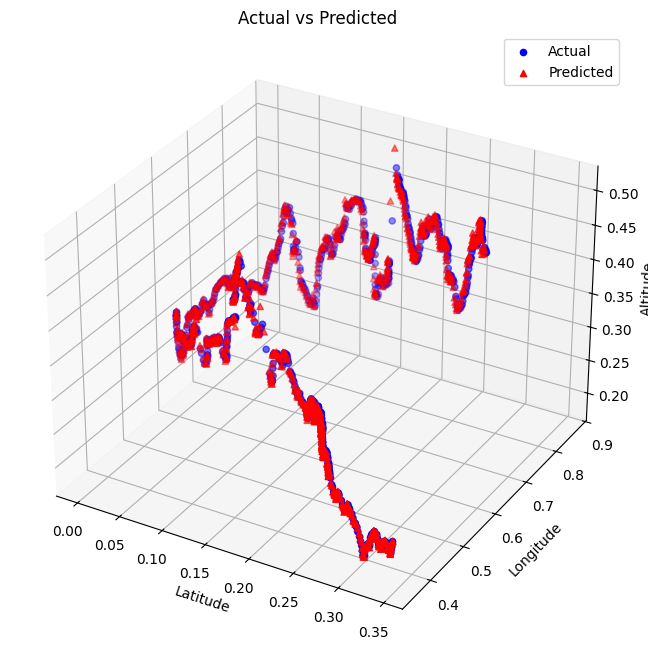

In [22]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

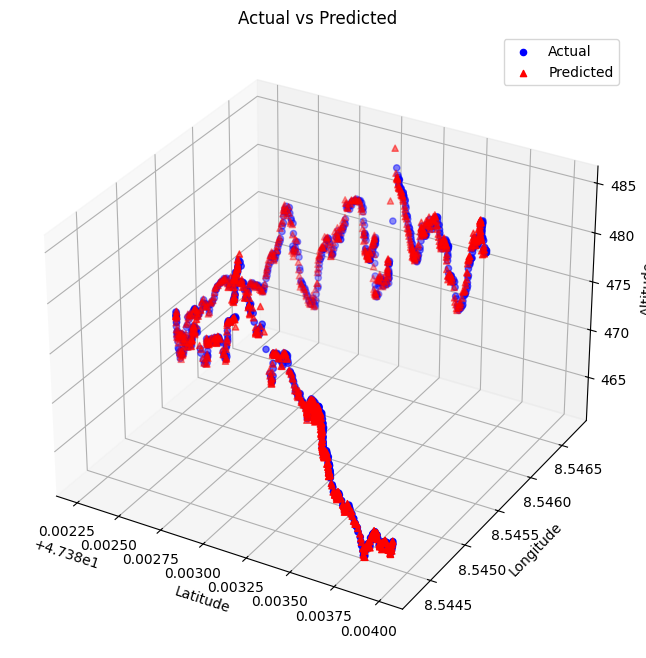

In [23]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

In [24]:
# plot_trajectory(train_data, val_data, test_data)

## Compare Models


### Model 비교 그래프

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits = [0, 0.01]):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [26]:
checkpoint = torch.load('./output_model/best_model_epoch_300.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

dict_keys(['model_state_dict', 'train_losses', 'val_losses'])


/tmp/ipykernel_33577/1353769495.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./output_model/best_model_epoch_300.pth')


### Val, Test data LOSS

In [27]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, y_limits=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Y축 수동 설정 (옵션)
    if y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss per Epoch', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.show()


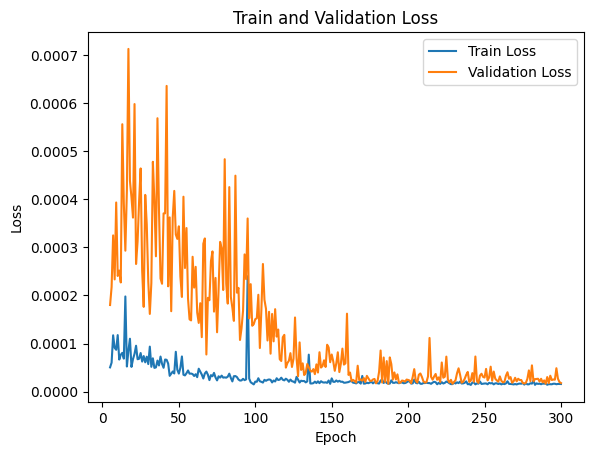

In [28]:
plt.plot(range(5, num_epochs + 1), train_losses[4:], label='Train Loss')
plt.plot(range(5, num_epochs + 1), val_losses[4:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

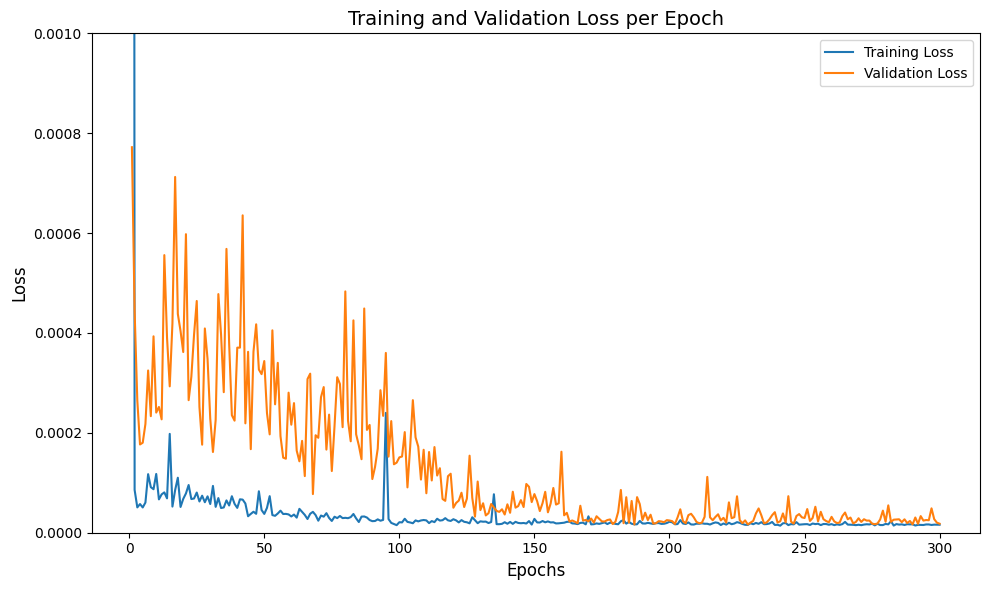

In [29]:
plot_losses(transformer_train_losses, transformer_val_losses, y_limits = (0, 0.001))